In [13]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
from io import StringIO
import time,json
from datetime import date

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
os.chdir(r'C:\Users\shubham\Desktop\case_study_python\12Time Series Analysis')

In [14]:
dataset = pd.read_csv('SeaPlaneTravel.csv')

In [15]:
dataset

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121
...,...,...
139,2015-08,606
140,2015-09,508
141,2015-10,461
142,2015-11,390


C:\Users\shubham\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


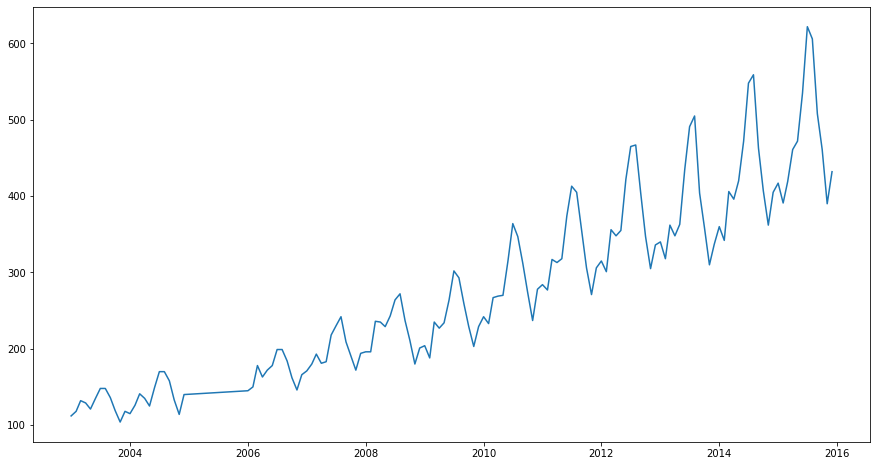

In [17]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
indexed_df = dataset.set_index('Month')
ts = indexed_df['#Passengers']
ts.head()
plt.plot(ts)

In [20]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries,autolag = 'AIC')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))

    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

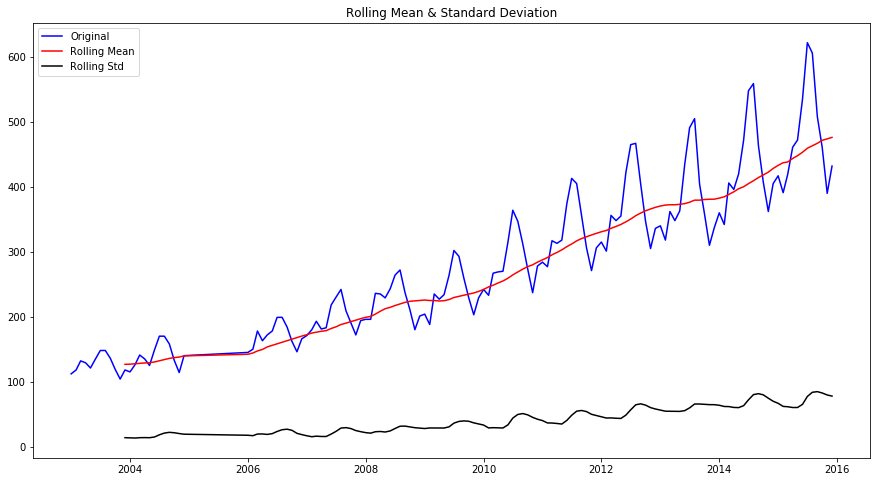

ADF Statistic: 0.8153688792060456
p-value: 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [21]:
get_stationarity(ts)

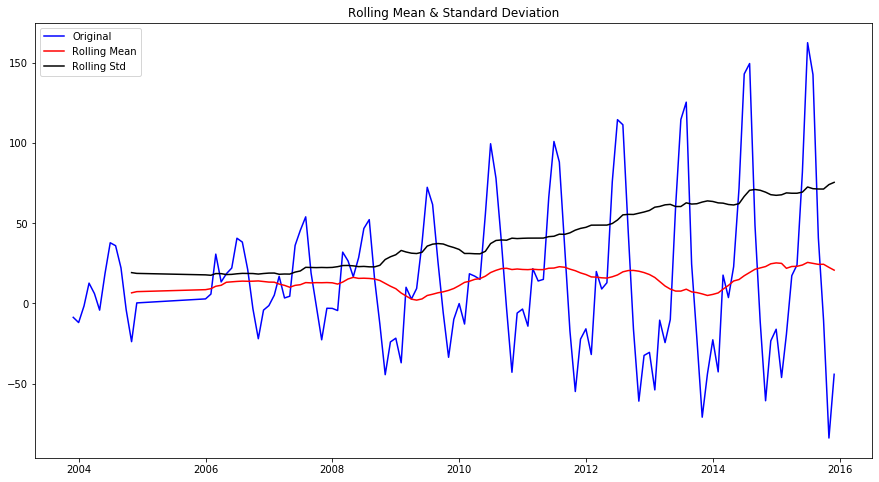

ADF Statistic: -3.1649681299551515
p-value: 0.022104139473878404
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [31]:
rolling_mean = ts.rolling(window=12).mean()
ts_mean = ts - rolling_mean
ts_mean.dropna(inplace=True)
get_stationarity(ts_mean)

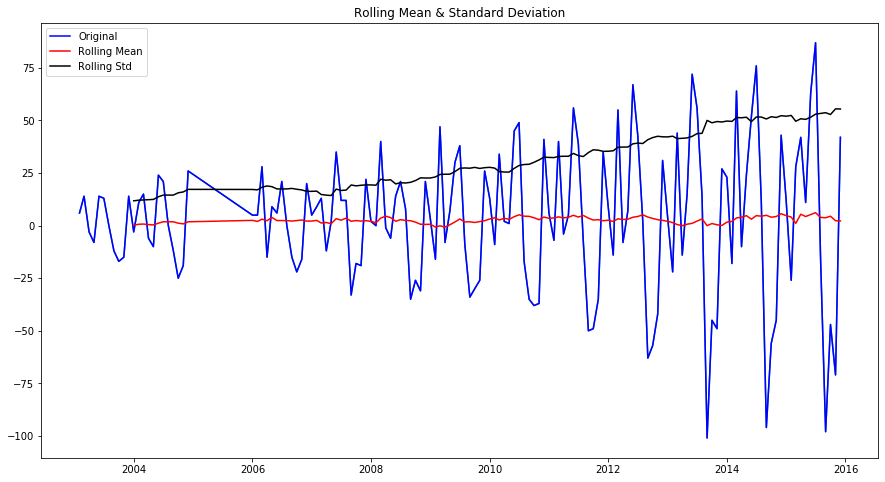

ADF Statistic: -2.8292668241699817
p-value: 0.05421329028382789
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [22]:
ts_diff = ts-ts.shift()
plt.plot(ts_diff)
ts_diff.dropna(inplace = True)
get_stationarity(ts_diff)

In [32]:
acf = acf(ts_mean,nlags = 10)
pacf = pacf(ts_mean,nlags = 10,method = 'ols')

TypeError: 'numpy.ndarray' object is not callable

In [33]:
      acf

array([ 1.        ,  0.30285526, -0.10214755, -0.24127349, -0.30040158,
       -0.09407271, -0.07844257, -0.0923622 , -0.29480158, -0.19177821,
       -0.10491707])

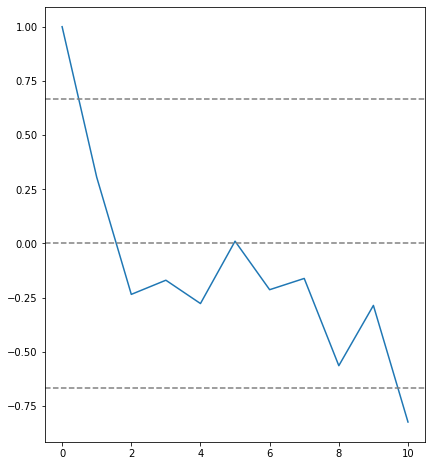

In [34]:
plt.subplot(121)
plt.plot(pacf)
plt.axhline(y=0 , linestyle = '--' , color = 'gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_diff)),linestyle = '--' , color = 'gray')
plt.axhline(y=7.96/np.sqrt(len(ts_diff)),linestyle = '--' , color = 'gray')


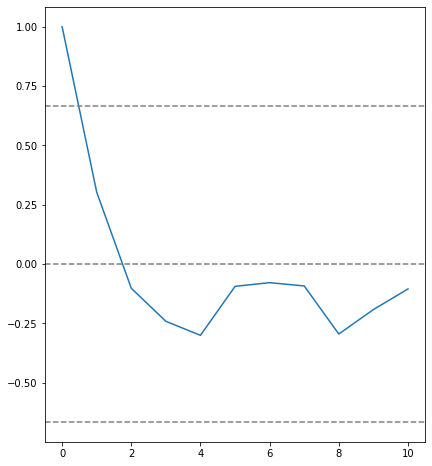

In [35]:
plt.subplot(122)
plt.plot(acf)
plt.axhline(y=0 , linestyle = '--' , color = 'gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_diff)),linestyle = '--' , color = 'gray')
plt.axhline(y=7.96/np.sqrt(len(ts_diff)),linestyle = '--' , color = 'gray')

C:\Users\shubham\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\shubham\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


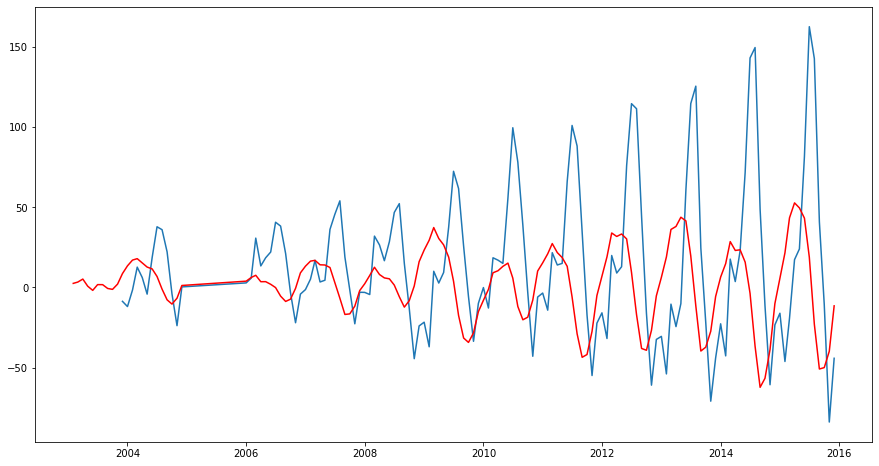

In [52]:
model = ARIMA(ts, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(ts_mean)
plt.plot(results.fittedvalues, color='red')

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.712
Date:                Thu, 09 Jul 2020   AIC                           1344.043
Time:                        17:30:48   BIC                           1361.820
Sample:                             1   HQIC                          1351.267
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.5309      0.708      3.573      0.000       1.143       3.919
ar.L1.D.#Passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.#Passeng

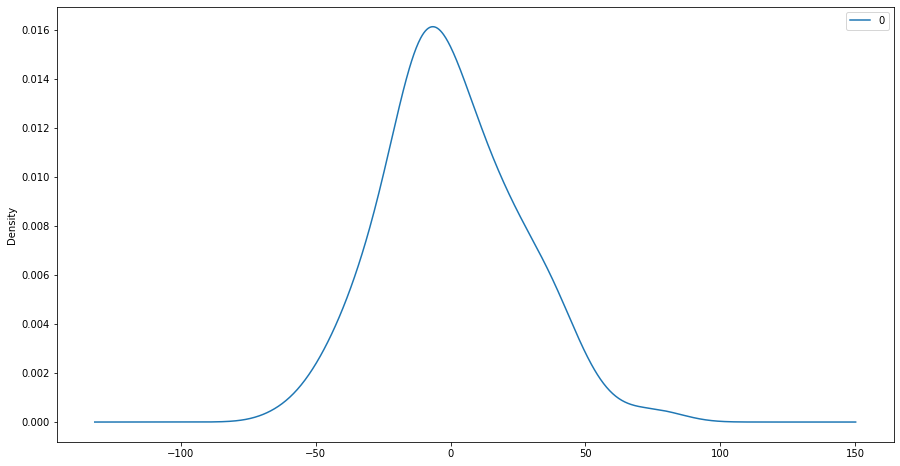

In [53]:
print(results.summary())
residuals = DataFrame(results.resid)
residuals.plot(kind = 'kde')
print(residuals.describe())

In [54]:
predictions_ARIMA_mean = pd.Series(results.fittedvalues , copy = True)
print(predictions_ARIMA_mean.head ())

Month
2003-02-01    2.530876
2003-03-01    3.350737
2003-04-01    5.221203
2003-05-01    0.789301
2003-06-01   -1.830876
dtype: float64


C:\Users\shubham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


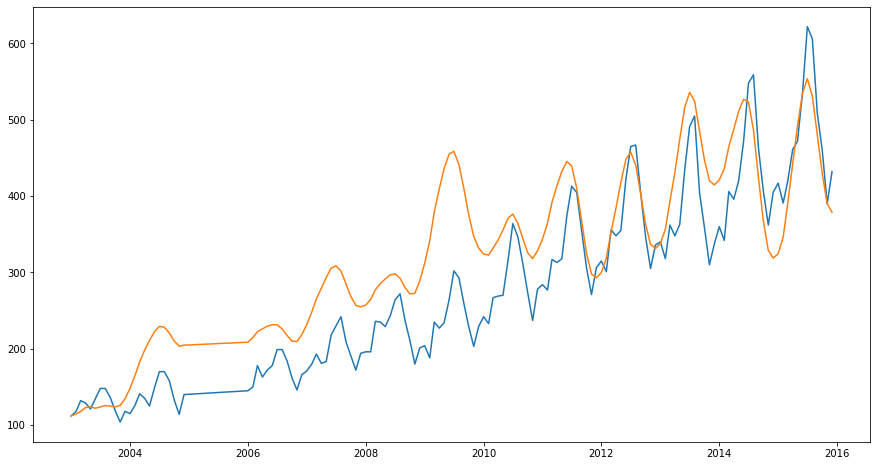

In [55]:
predictions_ARIMA_mean_cumsum = predictions_ARIMA_mean.cumsum()
predictions_ARIMA = pd.Series(ts.ix[0],index = ts.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_mean_cumsum,fill_value = 0)
plt.plot(ts)
plt.plot(predictions_ARIMA)

C:\Users\shubham\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\shubham\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\shubham\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


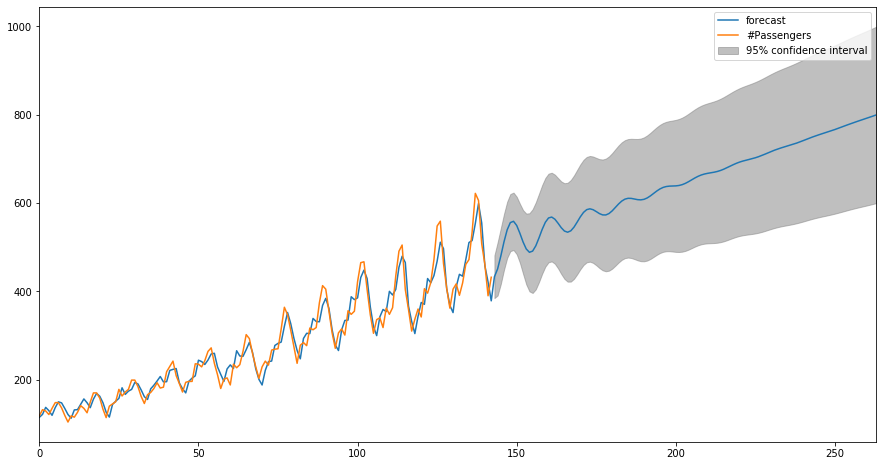

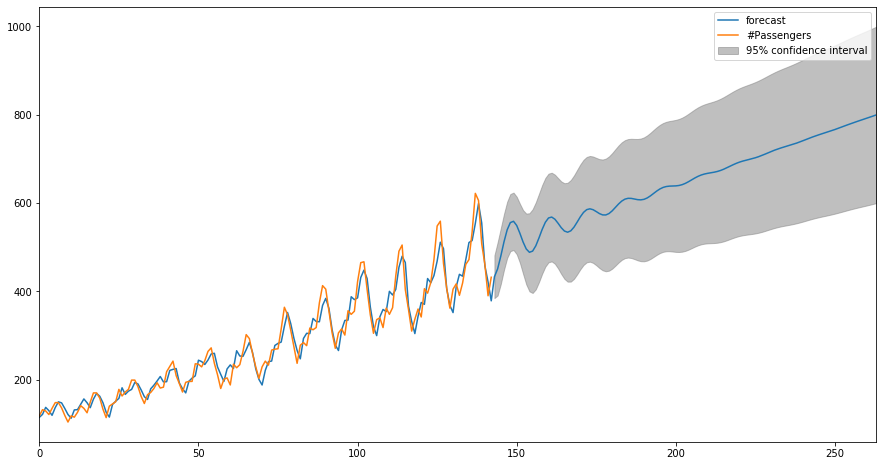

In [56]:
results.plot_predict(1,264)

In [57]:
# training and testing the dataset 

In [59]:
size = int(len(ts)-15)
train,test = ts[0:size] , ts[size:len(ts)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history,order = (2,1,2))
    model_fit = model.fit(disp = 0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)

In [67]:
error = mean_squared_error(test,predictions)
print('mean_squared_error is : ')
print(error)
predictions_series = pd.Series(predictions,index = test.index)

mean_squared_error is : 
1364.7704050253417


C:\Users\shubham\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  


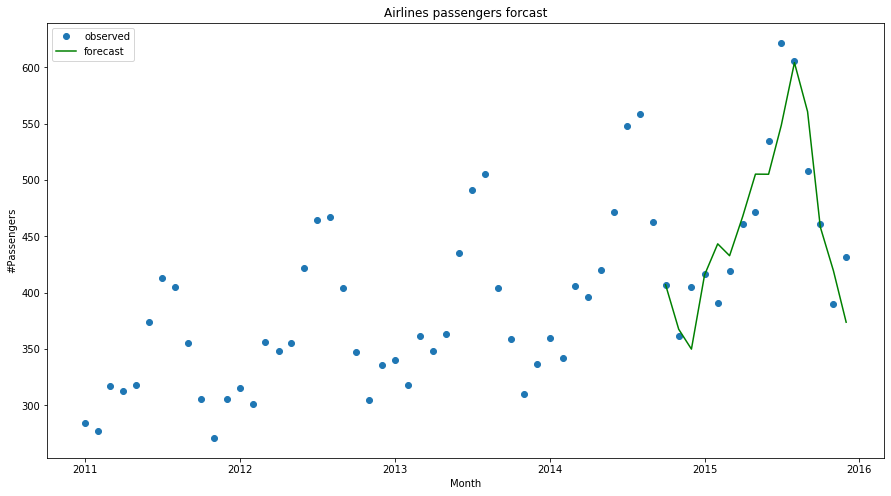

In [68]:
fig,ax = plt.subplots()
ax.set(title = 'Airlines passengers forcast' , xlabel = 'Month' , ylabel = '#Passengers')
ax.plot(ts[-60:],'o',label = 'observed')
ax.plot(predictions_series,'g',label = 'forecast')
legend = ax.legend(loc = 'upper left')
legend.get_frame().set_facecolor('W')